# Онлайн-хакатон Райффайзенбанка в области Data Science


Ключевая информация:

* Скор на паблике: 1.4241
* Примерное место на паблике: 43
* Обучение только на `price_type == 1`
* Рассказ про adversarial validation
* Рассказ про схему валидации
* Визуализация геоданных с помощью библиотеки keplergl


----

Установим необходимые библиотеки

In [1]:
pip install tqdm matplotlib catboost keplergl

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from tqdm.auto import tqdm

from keplergl import KeplerGl

np.random.seed(42)

Метрика, которую предоставили организаторы

In [3]:
def deviation_metric_one_sample(y_true, y_pred):
    deviation = (y_pred - y_true) / np.maximum(1e-8, y_true)
    if np.abs(deviation) <= 0.15: return 0
    elif deviation <= -0.6:       return 9.9
    elif deviation < -0.15:       return 1.1 * (deviation / 0.15 + 1) ** 2
    elif deviation < 0.6:         return (deviation / 0.15 - 1) ** 2
    return 9

def deviation_metric(y_true, y_pred):
    return np.array([deviation_metric_one_sample(y_true[n], y_pred[n]) for n in range(len(y_true))]).mean()

In [4]:
test = pd.read_csv('./data/test.csv').rename({'per_square_meter_price': 'target'}, axis=1)
test['train'] = 0
test['target'] = 0

train = pd.read_csv('./data/train.csv').rename({'per_square_meter_price': 'target'}, axis=1)
train['train'] = 1

dataset = pd.concat([train, test])

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Выделим важные колонки

In [5]:
key_cols = ['id', 'date', 'price_type', 'train', 'month', 'target']
cat_cols = ['city', 'osm_city_nearest_name', 'region', 'realty_type', 'street', 'floor']

Для удобства объединим выборки и добавим некоторые важные колонки.

Также отфильтруем датасет :)

In [6]:
dataset[cat_cols] = dataset[cat_cols].astype(str).fillna('NAN')
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['month'] = (
    dataset['date'].dt.floor('d') + pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)
)

dataset = dataset[dataset['price_type']==1]

# Небольшая визуализация

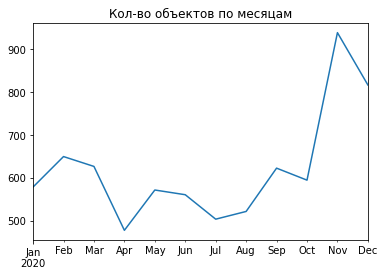

In [7]:
dataset['month'].value_counts().sort_index().plot(title='Кол-во объектов по месяцам');

Интересно, что в последние два месяца, объект гораздо больше, чем в другие месяцы...

Посмотрим, как географически распределены train и test:

In [8]:
kepler_data = {
    "test": dataset[dataset['train']==0][['lat', 'lng']],
    "train": dataset[dataset['train']==1][['lat', 'lng']],
}

map1 = KeplerGl(height=400, data=kepler_data)
map1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'test':             lat         lng
0     51.709255   36.147908
1     61.233240   73.462509
2  …

Выглядит достаточно равномерно

# Adversarial validation

В данном разделе проверим, насколько сильно наша обучающая выборка отличается от тестовой.


Для этого назовем `единичками` объекты из обучающей выбокри, `ноликами` - объекты из тестовой выборки.
И на исходных признаках построим модель машинного обучения, которая будет пытаться отличить обучающую выборку от тестовой на основе признаков.

Так как данные распределены по времени, то чтобы оценить качество нашей модели оставим по последнему месяцу из train и test.

Если выборки не отличаются, то качество такой модели должно быть случайной.

Для оценки качества модели будем использовать `ROC AUC`. Как мы знаем, `ROC AUC` случайного алгоритма должен быть в районе `0.5`.

In [9]:
oot_train_month_adv = '2020-08-01'
oot_val_month_adv = '2020-12-01'

Xy_train_adv = dataset[~dataset['month'].isin([oot_train_month_adv, oot_val_month_adv])].reset_index(drop=True)
Xy_test_adv = dataset[dataset['month'].isin([oot_train_month_adv, oot_val_month_adv])].reset_index(drop=True)


adv_model = CatBoostClassifier(verbose=100)
adv_model.fit(
    Xy_train_adv.drop(key_cols, axis=1), 
    Xy_train_adv['train'],
    cat_features=cat_cols
)


predict_adv = adv_model.predict(Xy_test_adv.drop(key_cols, axis=1))

print(roc_auc_score(Xy_test_adv['train'], predict_adv))

Learning rate set to 0.022342
0:	learn: 0.6909881	total: 58.8ms	remaining: 58.7s
100:	learn: 0.6161894	total: 1.11s	remaining: 9.9s
200:	learn: 0.5937461	total: 1.97s	remaining: 7.82s
300:	learn: 0.5767069	total: 2.77s	remaining: 6.43s
400:	learn: 0.5588018	total: 3.56s	remaining: 5.32s
500:	learn: 0.5380880	total: 4.49s	remaining: 4.47s
600:	learn: 0.5179787	total: 5.39s	remaining: 3.58s
700:	learn: 0.4999933	total: 6.25s	remaining: 2.67s
800:	learn: 0.4835562	total: 7.14s	remaining: 1.77s
900:	learn: 0.4679176	total: 7.97s	remaining: 876ms
999:	learn: 0.4541192	total: 8.81s	remaining: 0us
0.48765809873521015


Качество нашей модели получилось околослучайное, а значит все в порядке

# Модель

Прежде, чем строить модель, давайте разберемся, как будем валидироваться.

Как говорилось выше, данные распределены по времени, поэтому валидироваться не обходимо также по времени:

![alt text](https://miro.medium.com/max/558/1*AXRu72CV1hdjLfODFGbMWQ.png "Title")



In [10]:
# месяц с которого начнем валидироваться
start_month = '2020-04-01'

# месяцы для валидации
val_months = (
    dataset[(dataset['train']==1) & (dataset['month'] > start_month)]['month']
    .drop_duplicates()
    .sort_values()
    .tolist()
)

In [11]:
main_model = CatBoostRegressor(loss_function='MAE', verbose=0)

scores = []

for month in tqdm(val_months):
    Xy_train = dataset[(dataset['month'] < month)].reset_index(drop=True)
    Xy_val = dataset[(dataset['month'] == month)].reset_index(drop=True)
    
    model = clone(main_model)
    model = CatBoostRegressor(loss_function='MAE', verbose=0)
    model = model.fit(Xy_train.drop(key_cols, axis=1), Xy_train['target'], cat_features=cat_cols)

    metric = deviation_metric(Xy_val['target'], model.predict(Xy_val.drop(key_cols, axis=1)))
    scores.append(metric)
    
print(f'Средняя метрика по бинам: {np.mean(scores):.3f}')
print(f'Отклонение метрики по бинам: {np.std(scores):.3f}')


Средняя метрика по бинам: 1.594
Отклонение метрики по бинам: 0.160


In [12]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,city,8.071964
1,total_square,7.342278
2,floor,4.817922
3,realty_type,4.656558
4,osm_train_stop_closest_dist,3.711538
...,...,...
68,osm_building_points_in_0.01,0.200341
69,osm_healthcare_points_in_0.005,0.177565
70,osm_leisure_points_in_0.0075,0.161400
71,osm_building_points_in_0.001,0.131856


# Финальная модель

Обучим финальную модель и сделаем предикт

In [13]:
Xy_train = dataset[(dataset['train'] == 1)].reset_index(drop=True)
Xy_test = dataset[(dataset['train'] == 0)].reset_index(drop=True)

model = clone(main_model)
model = CatBoostRegressor(loss_function='MAE', verbose=0)
model = model.fit(Xy_train.drop(key_cols, axis=1), Xy_train['target'], cat_features=cat_cols)

In [14]:
Xy_test['per_square_meter_price'] = model.predict(Xy_test.drop(key_cols, axis=1))
Xy_test[['id', 'per_square_meter_price']].to_csv('sub1.csv', index=False)

# Дальнейшие идеи

* Покрутить признаки
* потюнить модель
* Подумать, что можно сделать с отфильтрованной частью датасета
* Поиспользовать внешние данные :)